######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

# ESML - accelerator: Batch scoring pipeline
- 1) `AutoMap datalake` & init ESML project
- 2) `Get earlier trained model`
- 3) `Score with GOLD_TEST` and calculate ML-performance




In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject
import pandas as pd
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
    

In [2]:
#p.describe()

In [3]:
try:
    print(p.GoldTest.to_pandas_dataframe().head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")

   Survived  Pclass                                         Name     Sex  \
0         1       3                              Mr. Sahid Nakid    male   
1         1       3                         Mr. Hanna Assi Barah    male   
2         0       3                            Mr. Edward Willey    male   
3         1       2                     Master. Viljo Hamalainen    male   
4         1       3  Mrs. Guillaume Joseph (Emma) de Messemaeker  female   

     Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0  20.00                        1                        1  15.7417  
1  20.00                        0                        0   7.2292  
2  21.00                        0                        0   7.5500  
3   0.67                        1                        1  14.5000  
4  36.00                        1                        0  17.4000  


p.inference_mode = False
datastore = p.init(ws)

esml_dataset = p.DatasetByName("ds01_titanic") 
df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
p.save_silver(esml_dataset,df_bronze) 
df = esml_dataset.Silver.to_pandas_dataframe() 
gold_train = p.save_gold(df)
label = "Survived"
train_set, validate_set, test_set = p.split_gold_3(0.6,label) 

# TEST_SET scoring: CLASSIFICATION
 - Autoregisters in Azure ML Studio, the TEST-scoring as TAGS on the GOLD_TEST dataset
 - locally on build server, or via pipeline.

from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task = 'classification', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = "Accuracy", # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = None,
                            training_data = None, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.922', # DEMO purpose (0.308 for diabetes regression, 0.6 for classification titanic)
                            label_column_name = "Survived"
                        )

automl_config.user_settings['label_column_name']

my_def_of_what_model_is_better_function = lambda sklearn_model_new,sklearn_model_current : (sklearn_model_new > sklearn_model_current) 

def my_function(my_lambda):
    model_a_new = 5
    model_b_current = 2
    if(my_lambda(model_a_new,model_b_current)):
        print("Model A, newly trained, is better")
    else:
        print("Model B, Current, is better")

my_function(my_def_of_what_model_is_better_function)

source_best_run.tags
source_best_run.id
source_best_run.properties['predicted_cost']
source_best_run.properties

Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0
Replacing tag run_i

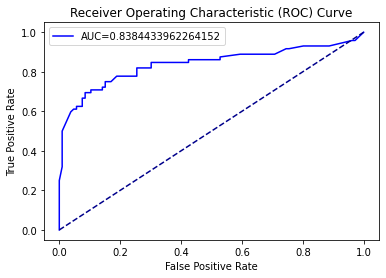

In [4]:
from baselayer_azure_ml import ESMLPipelineFactory

label = "Survived"
#rmse, r2, mean_abs_percent_error,accuracy,plt = ESMLPipelineFactory(p).get_test_scoring_4_regression(label)
auc,accuracy,f1, precision,recall,matrix, plt = ESMLPipelineFactory(p).get_test_scoring_7_classification(label)

print("AUC:")
print(auc)
print()
print("Accuracy:")
print(accuracy)
print()
print("F1 Score:")
print(f1)
print()
print("Precision:")
print(precision)
print()
print("Recall:")
print(recall)
print()
print("Confusion Matrix:")
print(matrix)


# END - CLASSIFICATION, TEST_SET scoring

# 2) CLASSIFICATION - predict_proba

In [14]:
# ESML specific start
source_best_run, fitted_model, experiment = p.get_best_model(p.ws)
X_test = p.GoldTest.to_pandas_dataframe() # X_test
# ESML end

from sklearn.metrics import mean_squared_error, r2_score,recall_score,average_precision_score,f1_score,roc_auc_score,accuracy_score,roc_curve,confusion_matrix

y_test = X_test.pop(label).to_frame() # y_test (true labels)
y_predict = fitted_model.predict(X_test) # y_predict (predicted labels)
y_predict_proba = fitted_model.predict_proba(X_test) # y_predict (predicted probabilities)

predict_proba = y_predict_proba[:, 1] # Positive values only
auc = roc_auc_score(y_test, predict_proba)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)

accuracy, precision, recall, f1, matrix = \
accuracy_score(y_test, y_predict),\
average_precision_score(y_test, y_predict),\
recall_score(y_test, y_predict),\
f1_score(y_test,y_predict), \
confusion_matrix(y_test, y_predict)


Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, current version:1.26.0

ROC AUC 0.97269231

In [15]:
print("ROC AUC", auc)

ROC AUC 0.9726923191116654


In [62]:
probs =  y_predict_proba[:, 1].tolist() # positive. negative: [:, 0]
result = {'predict_survive': y_predict.tolist(), 'probability': probs}
df_res = pd.DataFrame.from_dict(result)

all_result = X_test.join(df_res)
all_result.head()

,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,predict_survive,probability
0,3,Miss. Bridget O'Driscoll,female,27.00,0,0,7.75,1,0.92
1,2,Mrs. William John Robert (Dorothy Ann Wonnacot...,female,27.00,1,0,21.00,0,0.23
2,2,Master. Andre Mallet,male,1.00,0,2,37.00,1,0.98
3,1,Col. Oberst Alfons Simonius-Blumer,male,56.00,0,0,35.50,0,0.34
4,1,Miss. Jean Gertrude Hippach,female,16.00,0,1,57.98,1,1.00
